In [ ]:
# # uncomment this line to delete everything and start from scratch.
# # !rm -r /kaggle/working/*
!git clone https://github.com/Bini-jpeg/Handwritten-Ge-ez-Characters-Dataset.git

In [2]:
!unrar x Handwritten-Ge-ez-Characters-Dataset/Amharic\ Character\ Dataset\ 1.rar &>/dev/null
!unrar x Handwritten-Ge-ez-Characters-Dataset/Amharic\ Character\ Dataset\ 2.rar &>/dev/null
!unrar x Handwritten-Ge-ez-Characters-Dataset/additionals.rar &>/dev/null
!unrar x Handwritten-Ge-ez-Characters-Dataset/test_images.rar &>/dev/null

!mkdir organized_dataset
!mkdir dataset

!mv additionals/* organized_dataset
!rm -rf additionals/
    
!mv Amharic\ Character\ Dataset\ 1 dataset
!mv Amharic\ Character\ Dataset\ 2 dataset

In [ ]:
generate = True  # turn this to false if you dont want to generate data.
train = True     # turn this to false if you dont want to train the model.

In [5]:
# Imports
import os
import time
import random
import math
import re
import numpy as np
import string
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [4]:
import shutil

def organize_dataset(src_folder, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)

    # loop over each subdirectory in src_folder
    for subfolder in os.listdir(src_folder):
        subfolder_path = os.path.join(src_folder, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                # Expected filename format: "001_he.h19.jpg"
                match = re.match(r"(\d{3})", file)
                if match:
                    char_id = match.group(1)
                    target_folder = os.path.join(dest_folder, char_id)
                    os.makedirs(target_folder, exist_ok=True)

                    src_file = os.path.join(subfolder_path, file)
                    dest_file = os.path.join(target_folder, file)
                    shutil.move(src_file, dest_file)
                    # print(f"Moved {src_file} -> {dest_file}")
                else:
                    pass
                    # print(f"Filename {file} does not match expected pattern.")

if __name__ == '__main__':
    src_folder = 'dataset'
    dest_folder = 'organized_dataset'
    print("Organizing dataset...")
    organize_dataset(src_folder, dest_folder)
    print('done.')

# verify
!ls organized_dataset

In [6]:
CHARS1 = [
    "ሀ", "ሁ", "ሂ", "ሃ", "ሄ", "ህ", "ሆ", 
    "ለ", "ሉ", "ሊ", "ላ", "ሌ", "ል", "ሎ", 
    "ሐ", "ሑ", "ሒ", "ሓ", "ሔ", "ሕ", "ሖ",
    "መ", "ሙ", "ሚ", "ማ", "ሜ", "ም", "ሞ", 
    "ሠ", "ሡ", "ሢ", "ሣ", "ሤ", "ሥ", "ሦ", 
    "ረ", "ሩ", "ሪ", "ራ", "ሬ", "ር", "ሮ",
    "ሰ", "ሱ", "ሲ", "ሳ", "ሴ", "ስ", "ሶ", 
    "ሸ", "ሹ", "ሺ", "ሻ", "ሼ", "ሽ", "ሾ", 
    "ቀ", "ቁ", "ቂ", "ቃ", "ቄ", "ቅ", "ቆ",
    "በ", "ቡ", "ቢ", "ባ", "ቤ", "ብ", "ቦ", 
    "ቨ", "ቩ", "ቪ", "ቫ", "ቬ", "ቭ", "ቮ", 
    "ተ", "ቱ", "ቲ", "ታ", "ቴ", "ት", "ቶ",
    "ቸ", "ቹ", "ቺ", "ቻ", "ቼ", "ች", "ቾ", 
    "ኀ", "ኁ", "ኂ", "ኃ", "ኄ", "ኅ", "ኆ", 
    "ነ", "ኑ", "ኒ", "ና", "ኔ", "ን", "ኖ",
    "ኘ", "ኙ", "ኚ", "ኛ", "ኜ", "ኝ", "ኞ", 
    "አ", "ኡ", "ኢ", "ኣ", "ኤ", "እ", "ኦ", 
    "ከ", "ኩ", "ኪ", "ካ", "ኬ", "ክ", "ኮ",
    "ኸ", "ኹ", "ኺ", "ኻ", "ኼ", "ኽ", "ኾ", 
    "ወ", "ዉ", "ዊ", "ዋ", "ዌ", "ው", "ዎ", 
    "ዐ", "ዑ", "ዒ", "ዓ", "ዔ", "ዕ", "ዖ",
    "ዘ", "ዙ", "ዚ", "ዛ", "ዜ", "ዝ", "ዞ", 
    "ዠ", "ዡ", "ዢ", "ዣ", "ዤ", "ዥ", "ዦ", 
    "የ", "ዩ", "ዪ", "ያ", "ዬ", "ይ", "ዮ",
    "ደ", "ዱ", "ዲ", "ዳ", "ዴ", "ድ", "ዶ", 
    "ጀ", "ጁ", "ጂ", "ጃ", "ጄ", "ጅ", "ጆ", 
    "ገ", "ጉ", "ጊ", "ጋ", "ጌ", "ግ", "ጎ",
    "ጠ", "ጡ", "ጢ", "ጣ", "ጤ", "ጥ", "ጦ", 
    "ጨ", "ጩ", "ጪ", "ጫ", "ጬ", "ጭ", "ጮ", 
    "ጰ", "ጱ", "ጲ", "ጳ", "ጴ", "ጵ", "ጶ",
    "ጸ", "ጹ", "ጺ", "ጻ", "ጼ", "ጽ", "ጾ", 
    "ፀ", "ፁ", "ፂ", "ፃ", "ፄ", "ፅ", "ፆ", 
    "ፈ", "ፉ", "ፊ", "ፋ", "ፌ", "ፍ", "ፎ",
    "ፐ", "ፑ", "ፒ", "ፓ", "ፔ", "ፕ", "ፖ"
]

CHARS2 = [
    '፲', '፳', '፴', '፵', '፶', '፷', '፸', '፹', '፺', '፻','ቐ', 'ቑ', 'ቒ', 'ቓ', 'ቔ', 'ቕ', 
    'ቖ','ሏ', 'ሗ', 'ሟ', 'ሧ', 'ሯ', 'ሷ', 'ሿ','ቇ', 'ቧ', 'ቯ', 'ቷ', 'ቿ','ኗ', 'ኟ', 
    'ኰ', 'ኲ', 'ኳ', 'ኴ', 'ኵ','ዀ', 'ዃ', 'ዄ', 'ዅ','ጐ', 'ጒ', 'ጓ', 'ጔ', 'ጕ', '፩', 
    '፪', '፫', '፬', '፭', '፮', '፯', '፰', '፱', 'ኧ', 'ኯ','ዟ', 'ዧ', 'ዷ', 'ጇ', 'ጏ', 'ጧ', 
    'ጯ', 'ጷ', 'ጿ','ፏ', 'ፗ', '።', '፣', '፤', '፥','ቈ', 'ቊ', 'ቋ', 'ቌ', 'ቍ','ቘ', 'ቚ', 'ቛ', 'ቜ'
]

CHARS3 = [
    '!', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', 
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', 
    '=', '>', '?', '@', '[', ']', '^', '{', '}'
]

CHARS = CHARS1 + CHARS2 + CHARS3
print(len(CHARS), len(CHARS) == len(set(CHARS)))  # output should be: "353 True"

353 True


In [7]:
from PIL import Image, ImageDraw, ImageOps, ImageFilter, ImageEnhance
from numba import njit, prange

if generate:
    # ==========================================================
    # change this to any amount. recommended is 50,000 - 200,000
    NUM_IMAGES_TO_GENERATE = 100000
    # ==========================================================
    
    BASE_INPUT_DIR = "organized_dataset"
    BASE_OUTPUT_DIR = "generated_dataset"
    OUTPUT_IMAGE_DIR = f"{BASE_OUTPUT_DIR}/images"
    OUTPUT_TEXT_DIR = f"{BASE_OUTPUT_DIR}/text"
    CANVAS_WIDTH, CANVAS_HEIGHT = 600, 100
    BACKGROUND_COLOR = 0
    
    HORIZONTAL_PADDING = 0
    
    MIN_SCALE, MAX_SCALE = 1, 1.3
    MIN_CHAR_ROTATION, MAX_CHAR_ROTATION = -8, 8
    MIN_CHAR_SPACING, MAX_CHAR_SPACING = -3, 6
    MIN_WORD_SPACING, MAX_WORD_SPACING = 20, 28
    
    MIN_CHARS_PER_WORD, MAX_CHARS_PER_WORD = 2, 8
    MIN_WORDS_PER_LINE, MAX_WORDS_PER_LINE = 2, 6
    
    APPLY_SHEAR, MAX_SHEAR_FACTOR = True, 0.01
    APPLY_WAVE, WAVE_AMPLITUDE, WAVE_FREQUENCY = True, 1.5, 0.02
    APPLY_BLUR, MAX_BLUR_RADIUS = True, 0.1
    APPLY_GLOBAL_ROTATION, MAX_GLOBAL_ROTATION = True, 2
    APPLY_PERSPECTIVE, MAX_PERSPECTIVE_WARP = True, 0.001
    
    ADD_NOISE, NOISE_AMOUNT = True, 0.0003
    ADD_LINES, NUM_H_LINES = False, 2
    ADD_ORIENTED_LINES = False
    LINE_COLOR_MIN, LINE_COLOR_MAX = 180, 255
    HLINE_ANGLE_JITTER = 15
    
    APPLY_BRIGHTNESS_JITTER, BRIGHTNESS_RANGE = True, (0.95, 1.15)
    APPLY_CONTRAST_JITTER, CONTRAST_RANGE = True, (0.95, 1.15)
    
    @njit(parallel=True)
    def remap_vertical_wave_gray(src, offsets):
        h, w = src.shape
        dst = np.empty_like(src)
        for y in prange(h):
            for x in prange(w):
                y2 = y + offsets[x]
                if y2 < 0: y2 = 0
                elif y2 >= h: y2 = h - 1
                dst[y, x] = src[y2, x]
        return dst
    
    @njit
    def add_noise_jit_gray(src, num_noise, color):
        h, w = src.shape
        dst = src.copy()
        for i in range(num_noise):
            x = np.random.randint(0, w)
            y = np.random.randint(0, h)
            dst[y, x] = color
        return dst
    
    def apply_shear(img, factor):
        if abs(factor) < 1e-3: return img
        m = (1, factor, 0, 0, 1, 0)
        return img.transform(img.size, Image.AFFINE, m, Image.BILINEAR, fillcolor=BACKGROUND_COLOR)
    
    def apply_vertical_wave(img, amplitude, frequency):
        if amplitude < 0.1: return img
        arr = np.array(img)
        phase = random.random() * 2 * math.pi
        x = np.arange(arr.shape[1])
        offsets = (amplitude * np.sin(2 * math.pi * frequency * x + phase)).astype(np.int32)
        warped = remap_vertical_wave_gray(arr, offsets)
        return Image.fromarray(warped, mode='L')
    
    def apply_blur(img, max_radius):
        r = random.uniform(0, max_radius)
        if r > 0.1: return img.filter(ImageFilter.GaussianBlur(radius=r))
        return img
    
    def apply_global_rotation(img, max_deg):
        angle = random.uniform(-max_deg, max_deg)
        return img.rotate(angle, expand=True, fillcolor=BACKGROUND_COLOR)
    
    def find_perspective_coeffs(src_pts, dst_pts):
        A = []
        for (x0, y0), (x1, y1) in zip(src_pts, dst_pts):
            A.append([x0, y0, 1, 0, 0, 0, -x1*x0, -x1*y0])
            A.append([0, 0, 0, x0, y0, 1, -y1*x0, -y1*y0])
        A = np.array(A, dtype=float)
        B = np.array([coord for p in dst_pts for coord in p], dtype=float)
        return np.linalg.solve(A, B).tolist()
    
    def apply_perspective_transform(img, max_warp):
        w, h = img.size
        src = [(0,0),(w,0),(w,h),(0,h)]
        def rnd(): return random.uniform(-max_warp, max_warp)
        dst = [(w*rnd(),        h*rnd()),
               (w*(1+rnd()), h*rnd()),
               (w*(1+rnd()), h*(1+rnd())),
               (w*rnd(),        h*(1+rnd()))]
        coeffs = find_perspective_coeffs(src, dst)
        return img.transform((w, h), Image.PERSPECTIVE, coeffs, Image.BILINEAR, fillcolor=BACKGROUND_COLOR)
    
    def add_noise(img, amount):
        if amount <= 0: return img
        arr = np.array(img)
        n = int(amount * arr.shape[0] * arr.shape[1])
        color = random.randint(LINE_COLOR_MIN, LINE_COLOR_MAX)
        noisy = add_noise_jit_gray(arr, n, color)
        return Image.fromarray(noisy, mode='L')
    
    def add_horizontal_lines(img, num_lines):
        draw = ImageDraw.Draw(img)
        w, h = img.size
        for _ in range(num_lines):
            y0 = random.randint(int(0.1*h), int(0.9*h))
            dy = random.randint(-HLINE_ANGLE_JITTER, HLINE_ANGLE_JITTER)
            y1 = max(0, min(h, y0 + dy))
            color = random.randint(LINE_COLOR_MIN, LINE_COLOR_MAX)
            draw.line([(0, y0), (w, y1)], fill=color, width=1)
        return img
    
    def add_oriented_lines(img, num_lines):
        draw = ImageDraw.Draw(img)
        w, h = img.size
        for _ in range(num_lines):
            x0 = random.randint(0, w)
            y0 = random.randint(0, h)
            length = random.randint(int(0.05*w), int(0.3*w))
            ang = random.uniform(0, 2*math.pi)
            x1 = int(x0 + length*math.cos(ang))
            y1 = int(y0 + length*math.sin(ang))
            color = random.randint(LINE_COLOR_MIN, LINE_COLOR_MAX)
            draw.line([(x0, y0), (x1, y1)], fill=color, width=1)
        return img
    
    def _load_images_from_folder(folder_path):
        images = []
        valid_extensions = (".jpg", ".jpeg", ".png")
        try:
            if not os.path.isdir(folder_path):
                return images
            for f_name in os.listdir(folder_path):
                if f_name.lower().endswith(valid_extensions):
                    try:
                        img_path = os.path.join(folder_path, f_name)
                        images.append(Image.open(img_path).convert('L'))
                    except Exception:
                        pass
        except Exception:
            pass
        return images
    
    def load_char_images(base_dir, chars_list):
        char_map = {}
    
        for i, ch in enumerate(chars_list, 1):
            if ch in char_map:
                continue
    
            folder_name_numeric = f"{i:03d}"
            folder_path_numeric = os.path.join(base_dir, folder_name_numeric)
            
            loaded_imgs = _load_images_from_folder(folder_path_numeric)
            if loaded_imgs:
                char_map[ch] = loaded_imgs
    
        for ch in chars_list:
            if ch not in char_map:
                folder_name_char = str(ch)
                if folder_name_char in ['.', '..'] or '/' in folder_name_char or '\\' in folder_name_char:
                    continue
    
                folder_path_char_name = os.path.join(base_dir, folder_name_char)
                loaded_imgs = _load_images_from_folder(folder_path_char_name)
                if loaded_imgs:
                    char_map[ch] = loaded_imgs
        
        return char_map
    
    def generate_random_text(chars_available):
        words = []
        num_words = random.randint(MIN_WORDS_PER_LINE, MAX_WORDS_PER_LINE)
        for _ in range(num_words):
            word_len = random.randint(MIN_CHARS_PER_WORD, MAX_CHARS_PER_WORD)
            word = ''.join(random.choices(chars_available, k=word_len))
            words.append(word)
        return ' '.join(words)
    
    def create_text_image(text, char_map):
        canvas = Image.new('L', (CANVAS_WIDTH, CANVAS_HEIGHT), BACKGROUND_COLOR)
        x = random.randint(HORIZONTAL_PADDING, int(0.15*CANVAS_WIDTH))
        base_y = CANVAS_HEIGHT//2 + random.randint(-int(0.08*CANVAS_HEIGHT), int(0.08*CANVAS_HEIGHT))
    
        available_chars = list(char_map.keys())
    
        for ch in text:
            if x + 28*((MIN_SCALE+MAX_SCALE)/2) + MAX_CHAR_SPACING > CANVAS_WIDTH - HORIZONTAL_PADDING:
                break
    
            if ch == ' ':
                x += random.randint(MIN_WORD_SPACING, MAX_WORD_SPACING)
                continue
    
            if ch not in available_chars:
                x += 15
                continue
    
            imgs = char_map.get(ch)
            if not imgs:
                x += 15; continue
    
            ci = random.choice(imgs).copy()
    
            scale = random.uniform(MIN_SCALE, MAX_SCALE)
            new_width = max(1, int(ci.width * scale))
            new_height = max(1, int(ci.height * scale))
            if new_width > 0 and new_height > 0:
               try:
                   ci = ci.resize((new_width, new_height), Image.Resampling.LANCZOS)
               except ValueError:
                   print(f"Warning: Invalid size for resize ({new_width}, {new_height}). Skipping char '{ch}'.")
                   x += 15; continue
    
            char_rotation = random.uniform(MIN_CHAR_ROTATION, MAX_CHAR_ROTATION)
            ci = ci.rotate(char_rotation, expand=True, resample=Image.Resampling.BICUBIC, fillcolor=0)
    
            w, h = ci.size
            y_offset = random.randint(-int(0.04*CANVAS_HEIGHT), int(0.04*CANVAS_HEIGHT))
            y = base_y - h // 2 + y_offset
            y = max(0, min(y, CANVAS_HEIGHT - h))
    
            if x + w > CANVAS_WIDTH - HORIZONTAL_PADDING // 2 :
                 break
    
            canvas.paste(ci, (x, y), ci)
    
            x += w + random.randint(MIN_CHAR_SPACING, MAX_CHAR_SPACING)
    
        img = canvas
        if APPLY_SHEAR: img = apply_shear(img, random.uniform(-MAX_SHEAR_FACTOR, MAX_SHEAR_FACTOR))
        if APPLY_WAVE: img = apply_vertical_wave(img, random.uniform(0, WAVE_AMPLITUDE), random.uniform(0.7*WAVE_FREQUENCY, 1.3*WAVE_FREQUENCY))
        if APPLY_BLUR: img = apply_blur(img, MAX_BLUR_RADIUS)
        if APPLY_GLOBAL_ROTATION: img = apply_global_rotation(img, MAX_GLOBAL_ROTATION)
        original_size = img.size
        if APPLY_PERSPECTIVE:
            try:
                 img = apply_perspective_transform(img, MAX_PERSPECTIVE_WARP)
            except np.linalg.LinAlgError:
                 print("Warning: Perspective transform failed (singular matrix). Skipping.")
                 img = canvas
    
        if ADD_NOISE: img = add_noise(img, NOISE_AMOUNT)
        if ADD_LINES: img = add_horizontal_lines(img, NUM_H_LINES)
        if ADD_ORIENTED_LINES: img = add_oriented_lines(img, random.randint(1, NUM_H_LINES))
    
        if APPLY_BRIGHTNESS_JITTER:
            img = ImageEnhance.Brightness(img).enhance(random.uniform(*BRIGHTNESS_RANGE))
        if APPLY_CONTRAST_JITTER:
            img = ImageEnhance.Contrast(img).enhance(random.uniform(*CONTRAST_RANGE))
    
        return img
    
    def get_next_index(image_dir, text_dir):
        max_index = 0
        pattern = re.compile(r"line_(\d+)\.(png|txt)$")
    
        for dir_path in [image_dir, text_dir]:
            if not os.path.isdir(dir_path):
                continue
            for filename in os.listdir(dir_path):
                match = pattern.match(filename)
                if match:
                    index = int(match.group(1))
                    if index > max_index:
                        max_index = index
        return max_index + 1
    
    def generate_and_save(index, char_map, keys, img_dir, txt_dir):
        try:
            text = generate_random_text(keys)
            img = create_text_image(text, char_map)
            fname_base = f"line_{index:05d}"
            img_path = os.path.join(img_dir, fname_base + '.png')
            txt_path = os.path.join(txt_dir, fname_base + '.txt')
    
            img.save(img_path)
            with open(txt_path, 'w', encoding='utf-8') as f:
                f.write(text)
            return True
        except Exception as e:
            print(f"Error generating sample {index}: {e}")
            if 'img_path' in locals() and os.path.exists(img_path):
                 os.remove(img_path)
            if 'txt_path' in locals() and os.path.exists(txt_path):
                 os.remove(txt_path)
            return False
    
    if __name__ == '__main__':
        os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
        os.makedirs(OUTPUT_TEXT_DIR, exist_ok=True)
    
        try:
            char_map = load_char_images(BASE_INPUT_DIR, CHARS)
            available_chars = list(char_map.keys())
            if not available_chars:
                 print("Error: No character images were loaded. Exiting.")
                 exit()
    
            start_index = get_next_index(OUTPUT_IMAGE_DIR, OUTPUT_TEXT_DIR)
            print(f"Starting generation from index: {start_index}")
            print(f"Generating {NUM_IMAGES_TO_GENERATE} new images...")
    
            start_time = time.time()
            generated_count = 0
    
            for i in range(NUM_IMAGES_TO_GENERATE):
                current_index = start_index + i
                success = generate_and_save(current_index, char_map, available_chars, OUTPUT_IMAGE_DIR, OUTPUT_TEXT_DIR)
                if success:
                    generated_count += 1
    
                if (i + 1) % 10000 == 0 or (i + 1) == NUM_IMAGES_TO_GENERATE:
                     elapsed = time.time() - start_time
                     print(f"  Generated {generated_count}/{NUM_IMAGES_TO_GENERATE} (Index {current_index}). Total time: {elapsed:.2f}s")
    
    
            end_time = time.time()
            print(f"\nDone. Generated {generated_count} images in {end_time - start_time:.2f} seconds.")
            print(f"Output saved to: {BASE_OUTPUT_DIR}")
    
        except ValueError as ve:
             print(f"Setup Error: {ve}")
        except Exception as e:
             print(f"An unexpected error occurred: {e}")
else:
    print('[skipped data generation]')


[skipped data generation]


In [7]:
!pip3 install python-Levenshtein
import Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.9 MB/s eta 0:00:00:00:01


In [8]:
# -- Configuration and Seeds --
CTC_BLANK = '_'
NEW_CHARS = CTC_BLANK + ''.join(CHARS) + " "

char_to_int = {char: i for i, char in enumerate(NEW_CHARS)}
int_to_char = {i: char for char, i in char_to_int.items()}

DATASET_PATH = "generated_dataset"
IMAGE_DIR = os.path.join(DATASET_PATH, "images")
TEXT_DIR = os.path.join(DATASET_PATH, "text")

IMG_HEIGHT = 64
IMG_WIDTH = 384
BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-3
RNN_HIDDEN_SIZE = 256
RNN_LAYERS = 2
RANDOM_SEED = 42
TRAIN_PERCENTAGE = 0.9
VAL_PERCENTAGE = 0.1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = max(1, os.cpu_count() // 2)

if DEVICE.type == 'cuda':
    torch.backends.cudnn.benchmark = True

print(f"Using device: {DEVICE}")
print(f"Character set: '{NEW_CHARS}' (Length: {len(NEW_CHARS)})")

# data augmentation
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.Resampling.LANCZOS),
    transforms.RandomAffine(degrees=8, shear=8, scale=(0.85, 1.15), translate=(0.02, 0.02)),  # More augmentation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),  # Blur
    transforms.ColorJitter(brightness=0.2, contrast=(0.7, 1.3)),  # More contrast variation
    transforms.RandomApply([transforms.Lambda(lambda x: ImageOps.invert(x) if random.random() > 0.3 else x)], p=0.1),  # Inversion
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class HandwritingDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        with open(self.label_paths[idx], 'r', encoding='utf-8') as f:
            label = f.readline().strip()
        if self.transform:
            img = self.transform(img)
        encoded = torch.tensor([char_to_int[c] for c in label if c in char_to_int], dtype=torch.long)
        return img, encoded, label

def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return None
    imgs, labels, _ = zip(*batch)
    max_w = max(im.shape[2] for im in imgs)
    padded = [F.pad(im, (0, max_w - im.shape[2]), value=-1) for im in imgs]
    images_tensor = torch.stack(padded)
    lengths = torch.tensor([len(lbl) for lbl in labels], dtype=torch.long)
    labels_concat = torch.cat(labels)
    return images_tensor, labels_concat, lengths

def collate_fn_val(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return None
    imgs, labels, originals = zip(*batch)
    max_w = max(im.shape[2] for im in imgs)
    padded = [F.pad(im, (0, max_w - im.shape[2]), value=-1) for im in imgs]
    images_tensor = torch.stack(padded)
    lengths = torch.tensor([len(lbl) for lbl in labels], dtype=torch.long)
    labels_concat = torch.cat(labels) if labels else torch.tensor([], dtype=torch.long)
    return images_tensor, labels_concat, lengths, list(originals)

class CRNN(nn.Module):
    def __init__(self, img_channels, num_classes, rnn_hidden_size_cfg=256, rnn_layers_cfg=3, rnn_dropout=0.2):
        super().__init__()
        
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(img_channels, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.MaxPool2d((2,1)),
            nn.Dropout2d(0.1),
            
            # Block 4
            nn.Conv2d(256, 384, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(384),
            nn.MaxPool2d((2,1)),
            nn.Dropout2d(0.1),
        )
        
        # CNN output: H_out = IMG_HEIGHT / (2*2*2*2) = IMG_HEIGHT / 16
        # CNN output channels: 384
        self.rnn_input_features = 384 * (IMG_HEIGHT // 16)

        # LSTM
        self.rnn = nn.LSTM(
            input_size=self.rnn_input_features,
            hidden_size=rnn_hidden_size_cfg,
            num_layers=rnn_layers_cfg,
            bidirectional=True,
            batch_first=False,
            dropout=rnn_dropout if rnn_layers_cfg > 1 else 0.0
        )
        
        # attention
        self.attention = nn.MultiheadAttention(
            embed_dim=rnn_hidden_size_cfg * 2,
            num_heads=8,
            dropout=0.1,
            batch_first=False
        )
        
        # final layers with residual connection
        self.fc1 = nn.Linear(rnn_hidden_size_cfg * 2, rnn_hidden_size_cfg)
        self.fc2 = nn.Linear(rnn_hidden_size_cfg, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x shape: (batch, channels, height, width)
        features = self.cnn(x)
        # features shape: (batch, c_out, h_out, w_out)
        
        b, c_cnn, h_cnn, w_cnn = features.size()
        
        # Reshape for RNN: (w_out, batch, c_out * h_out)
        features = features.permute(0, 3, 1, 2)  # (b, w_cnn, c_cnn, h_cnn)
        features = features.reshape(b, w_cnn, c_cnn * h_cnn) # (b, w_cnn, rnn_input_features)
        features = features.permute(1, 0, 2)  # (w_cnn, b, rnn_input_features)
        
        # LSTM
        rnn_out, _ = self.rnn(features)
        # rnn_out shape: (w_cnn, b, rnn_hidden_size * 2)
        
        # Self-attention
        attn_out, _ = self.attention(rnn_out, rnn_out, rnn_out)
        
        # Residual connection
        combined = rnn_out + attn_out
        
        # Final classification layers
        output = self.fc1(combined)
        output = F.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output  # Output shape: (w_cnn, b, num_classes)

    def calc_input_lens(self, widths):
        # CNN downsamples width by 2 (first MaxPool) then 2 (second MaxPool) = 4 times
        return widths // 4

def decode_batch_predictions(preds):
    preds = F.log_softmax(preds, dim=2).permute(1, 0, 2)
    decoded_texts = []
    for seq in preds:
        max_inds = torch.argmax(seq, dim=1)
        collapsed = [i for i, ch in enumerate(max_inds) if i == 0 or ch != max_inds[i-1]]
        filtered = [ch for i, ch in enumerate(max_inds) if i in collapsed and ch != char_to_int[CTC_BLANK]]
        decoded_texts.append("".join(int_to_char[int(idx)] for idx in filtered))
    return decoded_texts

def calculate_cer(preds, targets):
    total_dist = sum(Levenshtein.distance(p, t) for p, t in zip(preds, targets))
    total_len = sum(len(t) for t in targets)
    return total_dist / total_len if total_len > 0 else 0

scaler = torch.amp.GradScaler()

def train_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc=f"Train Epoch {epoch+1}", leave=False):
        if batch is None:
            continue
        imgs, labels, lengths = batch
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(enabled=(device.type=='cuda'), device_type='cuda'):
            preds = model(imgs)
            input_lens = model.calc_input_lens(torch.tensor([im.shape[2] for im in imgs]))
            loss = criterion(F.log_softmax(preds, 2), labels, input_lens.to(device), lengths)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)  # Reduced grad clipping
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            if batch is None:
                continue
            imgs, labels, lengths, originals = batch
            imgs = imgs.to(device)
            preds = model(imgs)
            input_lens = model.calc_input_lens(torch.tensor([im.shape[2] for im in imgs]))
            loss = criterion(F.log_softmax(preds, 2), labels.to(device), input_lens.to(device), lengths)
            if not torch.isinf(loss):
                total_loss += loss.item()
            all_preds.extend(decode_batch_predictions(preds.cpu()))
            all_targets.extend(originals)
    cer = calculate_cer(all_preds, all_targets)
    return total_loss / len(loader), cer

def count_params(model):
    cnn_params = sum(p.numel() for name, p in model.named_parameters() if "cnn" in name and p.requires_grad)
    rnn_params = sum(p.numel() for name, p in model.named_parameters() if "rnn" in name and p.requires_grad)
    attn_params = sum(p.numel() for name, p in model.named_parameters() if "attention" in name and p.requires_grad)
    fc_params = sum(p.numel() for name, p in model.named_parameters() if "fc" in name and p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"# of params:")
    print(f"  CNN:        {cnn_params:,}")
    print(f"  RNN:        {rnn_params:,}")
    print(f"  Attention:  {attn_params:,}")
    print(f"  FC:         {fc_params:,}")
    print(f"-------------------------")
    print(f"  Total:      {total_params:,}")

Using device: cuda
Character set: '_ሀሁሂሃሄህሆለሉሊላሌልሎሐሑሒሓሔሕሖመሙሚማሜምሞሠሡሢሣሤሥሦረሩሪራሬርሮሰሱሲሳሴስሶሸሹሺሻሼሽሾቀቁቂቃቄቅቆበቡቢባቤብቦቨቩቪቫቬቭቮተቱቲታቴትቶቸቹቺቻቼችቾኀኁኂኃኄኅኆነኑኒናኔንኖኘኙኚኛኜኝኞአኡኢኣኤእኦከኩኪካኬክኮኸኹኺኻኼኽኾወዉዊዋዌውዎዐዑዒዓዔዕዖዘዙዚዛዜዝዞዠዡዢዣዤዥዦየዩዪያዬይዮደዱዲዳዴድዶጀጁጂጃጄጅጆገጉጊጋጌግጎጠጡጢጣጤጥጦጨጩጪጫጬጭጮጰጱጲጳጴጵጶጸጹጺጻጼጽጾፀፁፂፃፄፅፆፈፉፊፋፌፍፎፐፑፒፓፔፕፖ፲፳፴፵፶፷፸፹፺፻ቐቑቒቓቔቕቖሏሗሟሧሯሷሿቇቧቯቷቿኗኟኰኲኳኴኵዀዃዄዅጐጒጓጔጕ፩፪፫፬፭፮፯፰፱ኧኯዟዧዷጇጏጧጯጷጿፏፗ።፣፤፥ቈቊቋቌቍቘቚቛቜ!#$%&'()+,-./0123456789:;<=>?@[]^{} ' (Length: 355)


Total samples: 191872
Training samples: 172684
Val. samples: 19187
# of params:
  CNN:        3,360,192
  RNN:        5,251,072
  Attention:  1,050,624
  FC:         222,563
-------------------------
  Total:      9,884,451


Train Epoch 1:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/10 | Time: 753.52s | Train Loss: 5.9092 | Val Loss: 5.6586 | Val CER: 0.9970
New best CER: 0.9970


Train Epoch 2:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/10 | Time: 704.66s | Train Loss: 5.3012 | Val Loss: 4.4442 | Val CER: 0.8721
New best CER: 0.8721


Train Epoch 3:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/10 | Time: 704.35s | Train Loss: 3.4748 | Val Loss: 2.8795 | Val CER: 0.5789
New best CER: 0.5789


Train Epoch 4:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/10 | Time: 705.37s | Train Loss: 2.7689 | Val Loss: 2.5383 | Val CER: 0.5159
New best CER: 0.5159


Train Epoch 5:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/10 | Time: 703.67s | Train Loss: 2.5611 | Val Loss: 2.4375 | Val CER: 0.4932
New best CER: 0.4932


Train Epoch 6:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/10 | Time: 704.89s | Train Loss: 2.4691 | Val Loss: 2.3615 | Val CER: 0.4791
New best CER: 0.4791


Train Epoch 7:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/10 | Time: 705.55s | Train Loss: 2.4195 | Val Loss: 2.3297 | Val CER: 0.4748
New best CER: 0.4748


Train Epoch 8:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/10 | Time: 704.91s | Train Loss: 2.4786 | Val Loss: 2.3129 | Val CER: 0.4945


Train Epoch 9:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/10 | Time: 705.41s | Train Loss: 2.3773 | Val Loss: 2.2507 | Val CER: 0.4818


Train Epoch 10:   0%|          | 0/675 [00:00<?, ?it/s]

Validating:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/10 | Time: 704.33s | Train Loss: 2.3403 | Val Loss: 2.2565 | Val CER: 0.4838
Done. Best CER = 0.4748


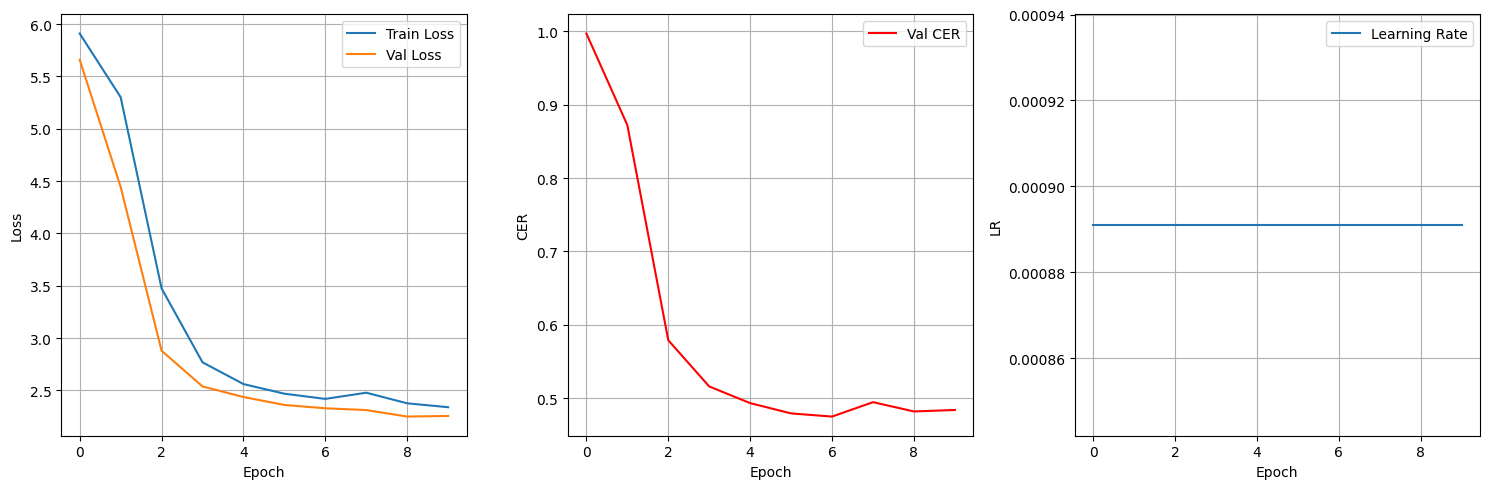

In [10]:
# training
if __name__ == '__main__' and train:
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    if DEVICE.type == 'cuda':
        torch.cuda.manual_seed_all(RANDOM_SEED)

    all_imgs = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    all_lbls = sorted([f for f in os.listdir(TEXT_DIR) if f.lower().endswith('.txt')])
    bases_img = {os.path.splitext(f)[0] for f in all_imgs}
    bases_lbl = {os.path.splitext(f)[0] for f in all_lbls}
    if bases_img != bases_lbl:
        common = list(bases_img & bases_lbl)
        all_image_paths = [os.path.join(IMAGE_DIR, f'{b}.png') for b in common]
        all_label_paths = [os.path.join(TEXT_DIR, f'{b}.txt') for b in common]
    else:
        all_image_paths = [os.path.join(IMAGE_DIR, f) for f in all_imgs]
        all_label_paths = [os.path.join(TEXT_DIR, f) for f in all_lbls]

    combined = list(zip(all_image_paths, all_label_paths))
    random.shuffle(combined)
    total_samples = len(combined)
    val_count = int(total_samples * VAL_PERCENTAGE)
    train_count = int(total_samples * TRAIN_PERCENTAGE)

    print(f"Total samples: {total_samples}")
    print(f"Training samples: {train_count}")
    print(f"Val. samples: {val_count}")

    val_split = combined[:val_count]
    train_split = combined[val_count:val_count+train_count]

    train_imgs, train_lbls = zip(*train_split)
    val_imgs, val_lbls = zip(*val_split)

    train_dataset = HandwritingDataset(list(train_imgs), list(train_lbls), transform=transform)
    val_dataset = HandwritingDataset(list(val_imgs), list(val_lbls), transform=transform)

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, collate_fn=collate_fn,
        pin_memory=(DEVICE.type=='cuda'), persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, collate_fn=collate_fn_val,
        pin_memory=(DEVICE.type=='cuda'), persistent_workers=True
    )

    model = CRNN(img_channels=1, num_classes=len(NEW_CHARS), rnn_hidden_size_cfg=RNN_HIDDEN_SIZE, rnn_layers_cfg=RNN_LAYERS).to(DEVICE)
    criterion = nn.CTCLoss(blank=char_to_int[CTC_BLANK], zero_infinity=True, reduction='mean')
    
    # Enhanced optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    # Cosine annealing scheduler with warm restarts
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6, verbose=True
    )

    
    count_params(model)
    
    best_cer = float('inf')
    train_losses, val_losses, val_cers = [], [], []
    patience_counter = 0
    patience = 10
    
    for epoch in range(EPOCHS):
        start_time = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch)
        val_loss, val_cer = validate_epoch(model, val_loader, criterion, DEVICE)
        scheduler.step()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_cers.append(val_cer)
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Time: {time.time() - start_time:.2f}s | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val CER: {val_cer:.4f}")
        
        if val_cer < best_cer:
            best_cer = val_cer
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best CER: {best_cer:.4f}")
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience and epoch > 15:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Done. Best CER = {best_cer:.4f}")

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(val_cers, label='Val CER', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot([scheduler.get_last_lr()[0] for _ in range(len(train_losses))], label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
lines = [
    "ብርኪ ሊሎ ኢኻ ገና", 
    "ግብፂ ሱዳን ዘፈረምካ ጅግና", 
    "ወዲ ሕዝቢ ኩርዓት ትግራይ", 
    "ዘይተወደአ ገና ኣላካ ውራይ", 
    "መንግስቲ ኢጣልያ ተንበርከኸ ኮታ", 
    "ሓውልቲ እንችመልስ ናብ መረበታ", 
    "ኣክሱም ዕልል በለት", 
    "አትዮጵያ ኮርዐት", 
    "ወለዲ ምሪቆም", 
    "ዕድመ ይሓብካ ኢሎም"
]


# —— Configuration —— #
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DIR     = "/kaggle/working/output_images"
MODEL_PATH   = "best_model.pth"
LINES        = lines
IMG_HEIGHT   = 64
IMG_WIDTH    = 384
CTC_BLANK    = '_'
do_preprocess = False   # already preprocessed to be black background and white test, with high contrast.

# —— Load model —— #
model = CRNN(img_channels=1, num_classes=len(NEW_CHARS), rnn_hidden_size_cfg=RNN_HIDDEN_SIZE, rnn_layers_cfg=RNN_LAYERS).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

inference_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.Resampling.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def infer_line(pil_image, model_instance, transform_fn, device_instance):
    img_tensor = transform_fn(pil_image)
    img_tensor = img_tensor.unsqueeze(0).to(device_instance)

    with torch.no_grad():
        logits = model_instance(img_tensor)

    log_probs = F.log_softmax(logits, dim=2)
    preds_permuted = log_probs.permute(1, 0, 2)
    max_indices = torch.argmax(preds_permuted, dim=2)[0].cpu().numpy()

    decoded_chars = []
    previous_char_index = None
    for idx in max_indices:
        if idx != previous_char_index and idx != char_to_int[CTC_BLANK]:
            if idx in int_to_char:
                 decoded_chars.append(int_to_char[idx])
        previous_char_index = idx
    return "".join(decoded_chars)

def cer(ref, hyp):
    return Levenshtein.distance(hyp, ref) / max(1, len(ref))

total_processed, cers_list = 0, []
for i, gt_text in enumerate(LINES, start=1):
    image_file_path = os.path.join(TEST_DIR, f"{i}.png")
    if not os.path.isfile(image_file_path):
        print(f"Missing {image_file_path}, skipping.")
        continue

    try:
        img_pil_gray = Image.open(image_file_path).convert("L")
    except Exception as e:
        print(f"Failed to load {image_file_path} with PIL: {e}, skipping.")
        continue

    predicted_text = infer_line(img_pil_gray, model, inference_transform, DEVICE)
    score = cer(gt_text, predicted_text)

    print(f"{i}. GT   : {gt_text!r}")
    print(f"   PRED : {predicted_text!r}")
    print(f"   CER  : {score:.3f}\n")

    cers_list.append(score)
    total_processed += 1

if total_processed:
    print(f"Processed {total_processed} lines. Average CER = {sum(cers_list)/total_processed:.3f}")
else:
    print("No test images processed.")

/tmp/ipykernel_31/4096563341.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


1. GT   : 'ብርኪ ሊሎ ኢኻ ገና'
   PRED : 'ብርኪ ሊሉ.ኢኻ ገና'
   CER  : 0.167

2. GT   : 'ግብፂ ሱዳን ዘፈረምካ ጅግና'
   PRED : 'ግብ8ሉጿጓ ዘፊምካ ጆግ9'
   CER  : 0.529

3. GT   : 'ወዲ ሕዝቢ ኩርዓት ትግራይ'
   PRED : 'ወጺ ሕዝቢ ኩር9ት ትግልይ'
   CER  : 0.188

4. GT   : 'ዘይተወደአ ገና ኣላካ ውራይ'
   PRED : 'ዘዪተወደአ 79 ኣ1ካ ውራ '
   CER  : 0.294

5. GT   : 'መንግስቲ ኢጣልያ ተንበርከኸ ኮታ'
   PRED : 'መዓዓከቷ ኢግልያ+9በርኮኸ ኮ '
   CER  : 0.500

6. GT   : 'ሓውልቲ እንችመልስ ናብ መረበታ'
   PRED : 'ሐወሒ እ9ትትመልለ9ብ መራታ'
   CER  : 0.632

7. GT   : 'ኣክሱም ዕልል በለት'
   PRED : 'ኣክኩም ዕፅል በለት'
   CER  : 0.167

8. GT   : 'አትዮጵያ ኮርዐት'
   PRED : 'ኢትዮጵዖ ኮርዐት'
   CER  : 0.200

9. GT   : 'ወለዲ ምሪቆም'
   PRED : 'ወለዪ ዖዐሪቆ ዖዐ'
   CER  : 0.750

10. GT   : 'ዕድመ ይሓብካ ኢሎም'
   PRED : 'ዕጽዑሬ ይሓብካ ኢሎይ '
   CER  : 0.417

Processed 10 lines. Average CER = 0.384


In [ ]:
import cv2
import numpy as np
from pathlib import Path

def process_image(image_path, output_path, target_size=(384, 64), squish_factor=0.8):
    img = cv2.imread(str(image_path))
    
    if img is None:
        print(f"Could not read image: {image_path}")
        return False
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 21, 10
    )
    
    inverted = cv2.bitwise_not(thresh)
    
    # clean up
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(inverted, cv2.MORPH_CLOSE, kernel)
    
    canvas = np.zeros((target_size[1], target_size[0]), dtype=np.uint8)
    
    squish_width = int(target_size[0] * squish_factor)
    squish_height = int(target_size[1] * squish_factor)
    
    resized_img = cv2.resize(cleaned, (squish_width, squish_height), interpolation=cv2.INTER_AREA)
    
    x_offset = (target_size[0] - squish_width) // 2
    y_offset = (target_size[1] - squish_height) // 2
    
    canvas[y_offset:y_offset+squish_height, x_offset:x_offset+squish_width] = resized_img
    
    cv2.imwrite(str(output_path), canvas)
    print(f"Processed: {image_path} -> {output_path}")
    return True

def process_folder(input_folder, output_folder, extensions=('.jpg', '.jpeg', '.png')):
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    image_files = []
    for ext in extensions:
        image_files.extend(Path(input_folder).glob(f'*{ext}'))
        image_files.extend(Path(input_folder).glob(f'*{ext.upper()}'))
    
    if not image_files:
        print(f"No images found in {input_folder}")
        return
    
    success_count = 0
    for image_path in image_files:
        output_path = Path(output_folder) / f"processed_{image_path.name}"
        if process_image(image_path, output_path):
            success_count += 1
    
    print(f"Processing complete. Successfully processed {success_count}/{len(image_files)} images.")

if __name__ == "__main__":
    input_folder = "input_images"
    output_folder = "processed_images"
    
    process_folder(input_folder, output_folder)